# Gold Price Predicition

### requirements.txt

seaborn==0.13.2
pandas==2.2.2
yfinance==0.2.40
matplotlib==3.9.0
scikit-learn==1.5.0
numpy==2.0.0
plotly==5.22.0
statsmodels==0.14.2
tensorflow==2.14.0
keras

## Problem Statement:
This project aims to leverage a comprehensive dataset of daily gold prices spanning from January 19,
2014, to January 22, 2024, obtained from Nasdaq. The dataset encompasses key financial metrics for
each trading day, including the opening and closing prices, trading volume, as well as the highest and
lowest prices recorded during the day.

## Dataset Description:
1. Date: A unique identifier for each trading day. (Mon-Fri) only open market days i.e, 5 days a week , 20 days a month , 250 days a year . 2500 days a decade
2. Close: Closing price of gold on the respective date.
3. Volume: Gold trading volume on the corresponding date.
4. Open: Opening price of gold on the respective date.
5. High: The highest recorded price of gold during the trading day.
6. Low: The lowest price recorded for gold in the trading day.


## Project Objectives:
* Time Series Analysis
* Advanced Modeling
* Trading Strategy Development
* Market Sentiment Analysis
* Statistical Analysis

## Expected Deliverables:
*  Time series visualizationsillustrating trends and patterns.
*  Predictive modelsfor future gold price forecasting.
*  Back-tested trading strategies with performance metrics.
*  Marketsentiment analysis reports highlighting key events and their impact.
*  Statistical analyses providing insights into the characteristics of gold price movements.

Importing necessary libraries 

In [2]:
import os
import math
import joblib
from scipy import stats
import numpy as np 
import pandas as pd 
from pandas.plotting import autocorrelation_plot # lag days
import matplotlib.pyplot as plt # visualization
import seaborn as sns
from statsmodels.tsa.stattools import adfuller # null-hypothesis tesing
from statsmodels.tsa.seasonal import seasonal_decompose # Visualize the trends & seasonality

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler  # to scale down Close price data in range between(0,1) original data is sensitive for LSTM

Unfortunately Datetime cannot be used to train model. Therefore, we take out month and day from it as separate column

# Data Preprocessing

* Dataset: The code reads a CSV file goldstock.csv containing daily gold prices from January 19, 2014, to January 22, 2024, with columns for date, closing price, volume,opening price, highest price, and lowest price.

In [3]:
if os.path.exists('goldstock.csv'):
    gold = pd.read_csv('goldstock.csv',header=0,index_col='Date',parse_dates=True)

gold = gold.drop('Unnamed: 0',axis=1)
gold = gold.dropna()

df2 = gold.copy()

Considerations:

* Users are advised to validate the accuracy and reliability of the information.
* Be aware of limitations and biases inherent in financial databases.
* Acknowledge the potential impact of external events on gold prices.


Expected Deliverables:
* Time series visualizationsillustrating trends and patterns.
* Predictive modelsfor future gold price forecasting.
* Back-tested trading strategies with performance metrics.
* Marketsentiment analysis reports highlighting key events and their impact.
* Statistical analyses providing insights into the characteristics of gold price movements

* Data Cleaning: The data is cleaned by setting the date as the index and dropping unnecessary columns.

In [4]:
gold

,Close,Volume,Open,High,Low
Date,,,,,
2024-01-19,2029.3,166078.0,2027.4,2041.9,2022.2
2024-01-18,2021.6,167013.0,2009.1,2025.6,2007.7
2024-01-17,2006.5,245194.0,2031.7,2036.1,2004.6
2024-01-16,2030.2,277995.0,2053.4,2062.8,2027.6
2024-01-12,2051.6,250946.0,2033.2,2067.3,2033.1
...,...,...,...,...,...
2014-01-28,1250.5,81426.0,1254.9,1261.9,1248.0
2014-01-27,1263.5,63419.0,1269.9,1280.1,1252.0
2014-01-24,1264.5,34998.0,1264.3,1273.2,1256.9


* Feature Engineering

<Axes: xlabel='Date'>

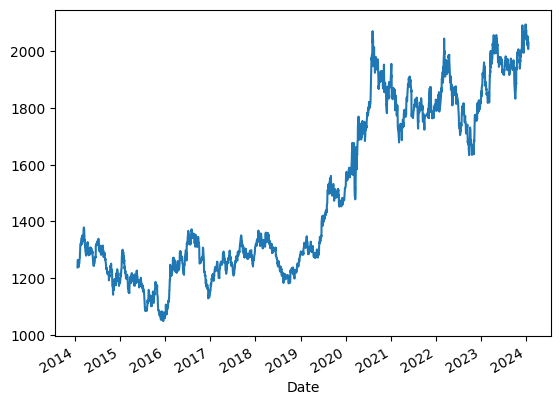

In [5]:
gold['Close'].plot()

it can be seen that the 'Close' is too irregulary, without any actual trends & smoothness & thus we have the need of feature engineering

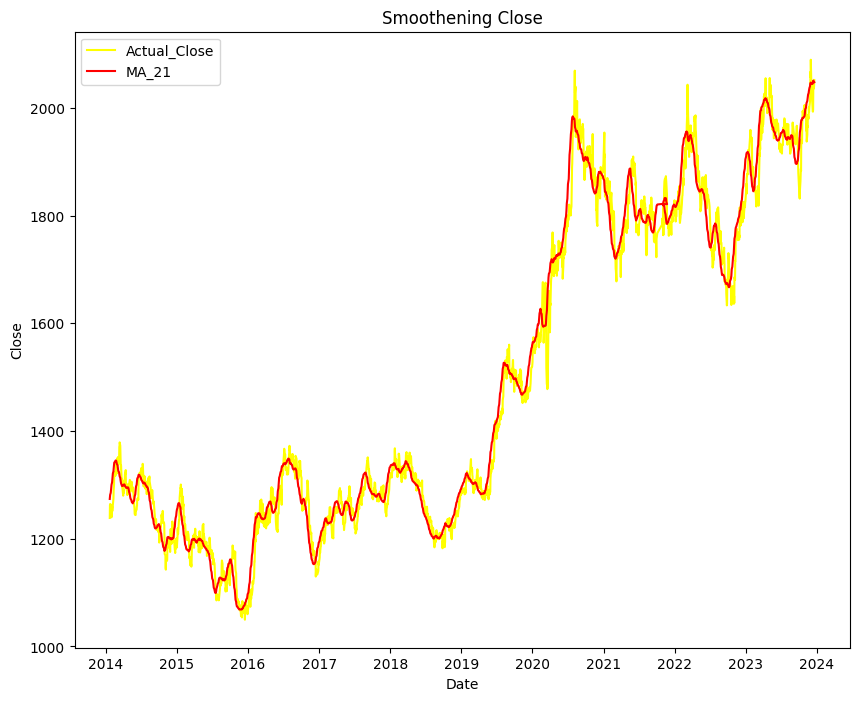

In [6]:
gold['MovingAverage_month']=gold['Close'].rolling(window=21).mean() #month
# gold['MovingAverage_year']=gold['Close'].rolling(window=252).mean() #year
gold['Close_diff2']=gold['Close'].shift(2)
gold['Close_log'] = np.log(gold['Close'])

gold = gold.dropna()

plt.figure(figsize=(10,8))
plt.plot(gold.index, gold.Close, label='Actual_Close',color='yellow')
plt.plot(gold.index, gold.MovingAverage_month, label='MA_21',color='red') #trend showcasing for each month
# plt.plot(gold.index, gold.MovingAverage_year, label='MA_252',color='green') #trend showcasing for each year
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Smoothening Close')
plt.legend()
plt.show()

this hows that the overall trend for graph for long-term is upward

In [7]:
gold

,Close,Volume,Open,High,Low,MovingAverage_month,Close_diff2,Close_log
Date,,,,,,,,
2023-12-19,2052.1,130031.0,2041.1,2061.0,2034.8,2047.957143,2051.3,7.626619
2023-12-18,2040.5,137436.0,2033.3,2048.0,2029.5,2048.490476,2047.7,7.620950
2023-12-15,2035.7,166565.0,2051.3,2059.6,2029.2,2049.161905,2052.1,7.618595
2023-12-14,2044.9,222776.0,2043.2,2062.9,2039.1,2050.990476,2040.5,7.623104
2023-12-13,1997.3,183780.0,1995.1,2043.3,1987.9,2049.423810,2035.7,7.599552
...,...,...,...,...,...,...,...,...
2014-01-28,1250.5,81426.0,1254.9,1261.9,1248.0,1288.347619,1242.5,7.131299
2014-01-27,1263.5,63419.0,1269.9,1280.1,1252.0,1285.276190,1262.2,7.141641
2014-01-24,1264.5,34998.0,1264.3,1273.2,1256.9,1281.552381,1250.5,7.142432


# Visualization

## Time series & Statistical analysis

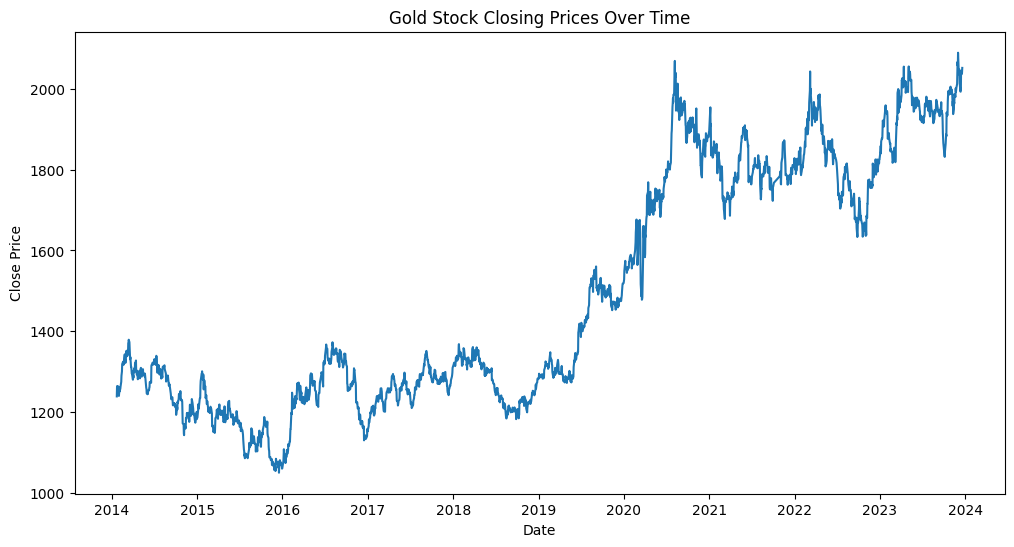

In [8]:
# Line plot for closing prices over time
plt.figure(figsize=(12, 6))
sns.lineplot(x=gold.index, y='Close', data=gold)
plt.title('Gold Stock Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

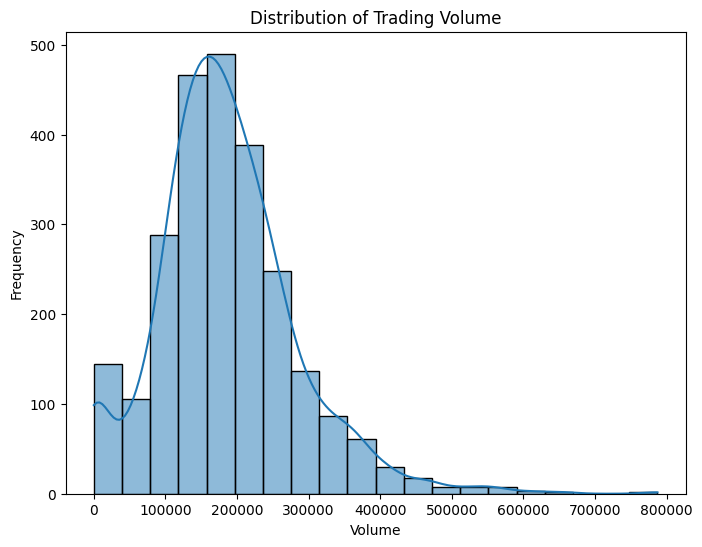

In [9]:
# Histogram of trading volume
plt.figure(figsize=(8, 6))
sns.histplot(gold['Volume'], bins=20, kde=True)
plt.title('Distribution of Trading Volume')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.show()

Duplicate index values found. Removing duplicates...


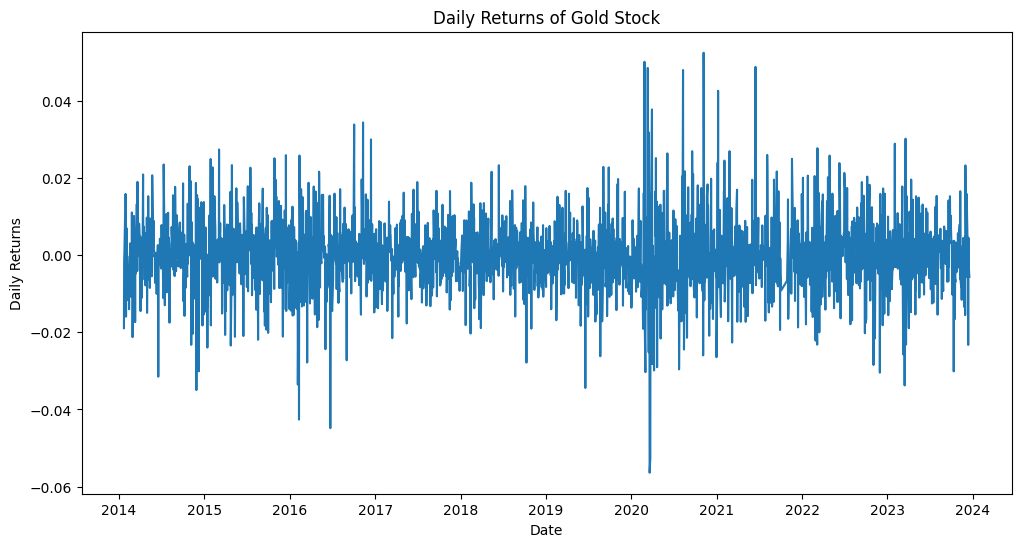

In [10]:
# Daily Returns Plot
# Check for duplicate index values
duplicate_index = gold.index.duplicated()
if duplicate_index.any():
    print("Duplicate index values found. Removing duplicates...")
    gold = gold[~duplicate_index]  # Keep only the first occurrence of each date

# Calculate daily returns
gold['Daily Returns'] = gold['Close'].pct_change()

# Plot daily returns
plt.figure(figsize=(12, 6))
sns.lineplot(x=gold.index, y='Daily Returns', data=gold)
plt.title('Daily Returns of Gold Stock')
plt.xlabel('Date')
plt.ylabel('Daily Returns')
plt.show()

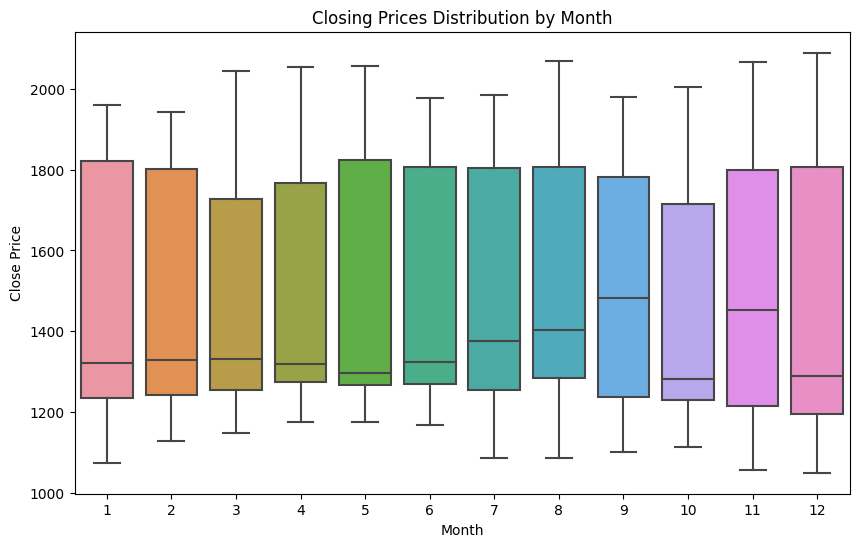

In [11]:
# Box Plot for Closing Prices by Month  -----------Noise
gold['Month'] = gold.index.month
plt.figure(figsize=(10, 6))
sns.boxplot(x='Month', y='Close', data=gold)
plt.title('Closing Prices Distribution by Month')
plt.xlabel('Month')
plt.ylabel('Close Price')
plt.show()

In [ ]:
sns.pairplot(gold)

removing outlies for better performance

In [12]:
'''
  -----DEPENDING UPON WHERE THE OUTLIER LIES--------
uv = upper_value
lv = lower_value

if ( value_ > 99th percentile ) :
--> value = 3 * uv 

if ( value_ < 1st percentile ) :
--> value = 0.3 * lv 
'''

# Calculate Z-score for volume
z_scores = stats.zscore(gold['Volume'])

# Define a threshold for outlier detection based on Z-score
threshold = 3  # Adjust as necessary
outliers = (abs(z_scores) > threshold)

# Remove outliers from the DataFrame
gold = gold[~outliers]

In [ ]:
# after removing outliers

sns.pairplot(gold)

<Figure size 1500x1000 with 0 Axes>

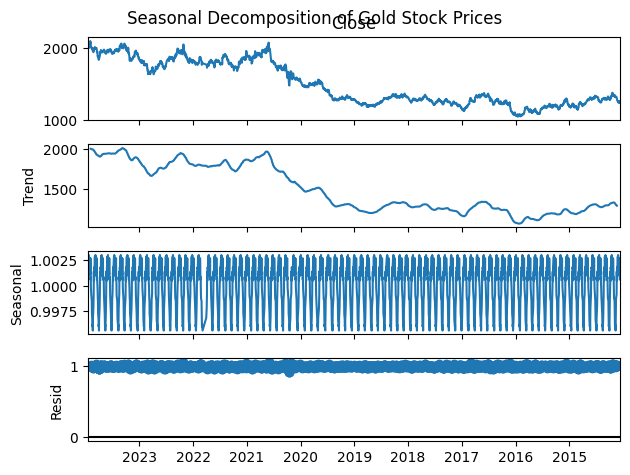

In [13]:
# Seasonal Decomposition Plot
result = seasonal_decompose(gold['Close'], model='multiplicative', period=30)  # Assuming a period of 30 days for seasonality
plt.figure(figsize=(15, 10))
result.plot()
plt.suptitle('Seasonal Decomposition of Gold Stock Prices')
plt.show()

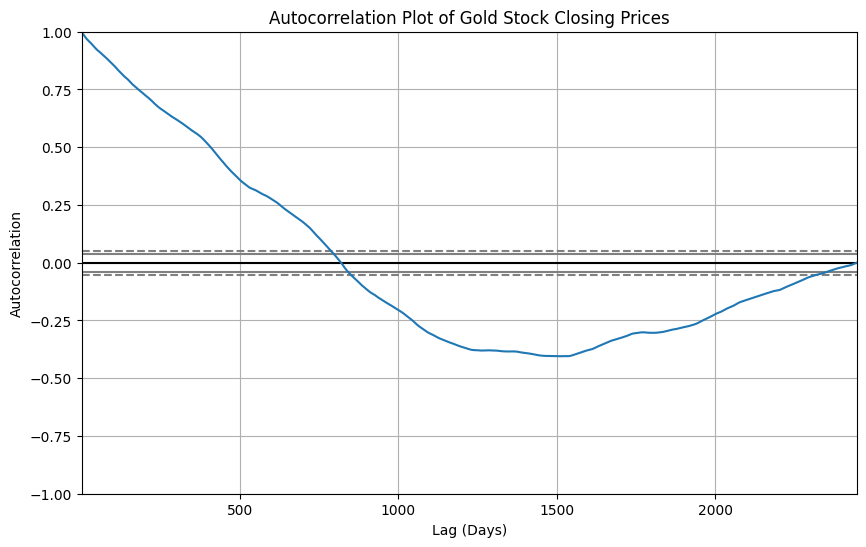

In [14]:
# Autocorrelation Plot
plt.figure(figsize=(10, 6))
autocorrelation_plot(gold['Close'])
plt.title('Autocorrelation Plot of Gold Stock Closing Prices')
plt.xlabel('Lag (Days)')
plt.ylabel('Autocorrelation')
plt.show()

<Axes: >

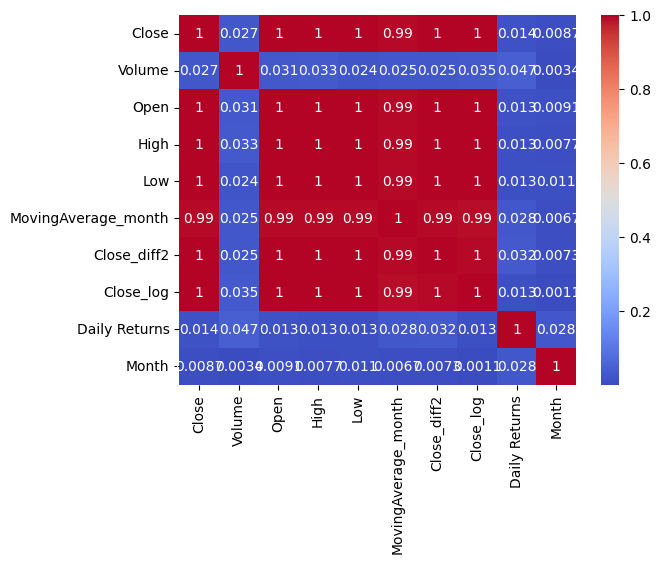

In [15]:
sns.heatmap(gold.corr().abs(),cmap='coolwarm',annot=True)

In [16]:
gold = gold.dropna() 
gold

,Close,Volume,Open,High,Low,MovingAverage_month,Close_diff2,Close_log,Daily Returns,Month
Date,,,,,,,,,,
2023-12-18,2040.5,137436.0,2033.3,2048.0,2029.5,2048.490476,2047.7,7.620950,-0.005653,12
2023-12-15,2035.7,166565.0,2051.3,2059.6,2029.2,2049.161905,2052.1,7.618595,-0.002352,12
2023-12-14,2044.9,222776.0,2043.2,2062.9,2039.1,2050.990476,2040.5,7.623104,0.004519,12
2023-12-13,1997.3,183780.0,1995.1,2043.3,1987.9,2049.423810,2035.7,7.599552,-0.023277,12
2023-12-12,1993.2,140257.0,1997.8,2012.5,1992.3,2046.642857,2044.9,7.597497,-0.002053,12
...,...,...,...,...,...,...,...,...,...,...
2014-01-28,1250.5,81426.0,1254.9,1261.9,1248.0,1288.347619,1242.5,7.131299,-0.009270,1
2014-01-27,1263.5,63419.0,1269.9,1280.1,1252.0,1285.276190,1262.2,7.141641,0.010396,1
2014-01-24,1264.5,34998.0,1264.3,1273.2,1256.9,1281.552381,1250.5,7.142432,0.000791,1


* from this we can state that Close price depends upon ['Open','High','Low','Month','Day'] as major factors & comparatively less on ['Volume']

In [18]:
# setting up features

predictors = ['Volume','Open','High','Low','Month']
target = ['Close']

# Modeling | Regression Model Development 

In [19]:
# function to visualize results

def plot_results(test_X,test_y,preds):
    plt.plot(gold.index, gold.Close, label='Actual')
    plt.plot(test_y.index, preds, label='Predicted')
    plt.xlabel('Date')
    plt.ylabel('Close')
    plt.title('Stock Price Prediction')
    plt.legend()
    plt.show()

In [20]:
## Code for Backtesting

def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Close"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Close"], preds], axis=1)
    return combined

def backtest(data, model, predictors, start=250, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [21]:
# Column wise Data Splitting 

X = gold[predictors]
y = gold[target]

# Train & Test Splitting

train_X = X[300:]
test_X = X[:300]
train_y = y[300:]
test_y = y[:300]

## Random Forest Regressor

In [22]:
r_model = RandomForestRegressor()

r_model.fit(train_X,train_y)

score_r_ = r_model.score(test_X,test_y)

print(score_r_)

0.9886964504738244


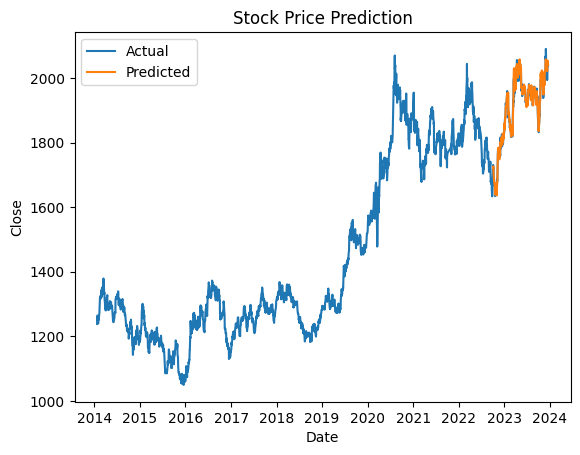

In [23]:
# let's visualize the score,predictions by predicting againt test data

preds = r_model.predict(test_X) 
preds = pd.Series(preds, index=test_X.index)
r_model.score(test_X,test_y)

plot_results(test_X,test_y,preds)

We've got a good score let's test using Backtest #0.9993370597024275 

In [24]:
backtest(gold,r_model,predictors)

score_r_bt = r_model.score(test_X,test_y)

print(score_r_bt)

0.9990105995125053


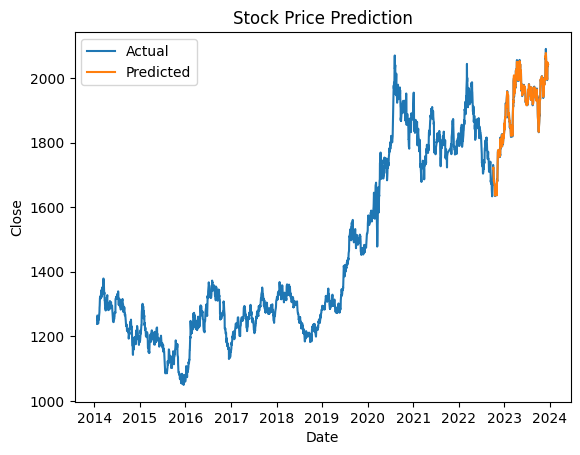

In [25]:
# let's visualize the score,predictions by predicting againt test data

preds = r_model.predict(test_X) 
preds = pd.Series(preds, index=test_X.index)

plot_results(test_X,test_y,preds)

## Linear Regressor

Sure there is an improvement after backtesting #0.9998822710417274

* Important Note :
The disturbed graph is nothing but a result of higher count of test records if we use only 200-300 record the visualization would be clear but the models score will get affected & decrease significantly

In [26]:
l_model = LinearRegression()

l_model.fit(train_X,train_y)

score_l_ = l_model.score(test_X,test_y)

print(score_l_)

0.9955076974046257


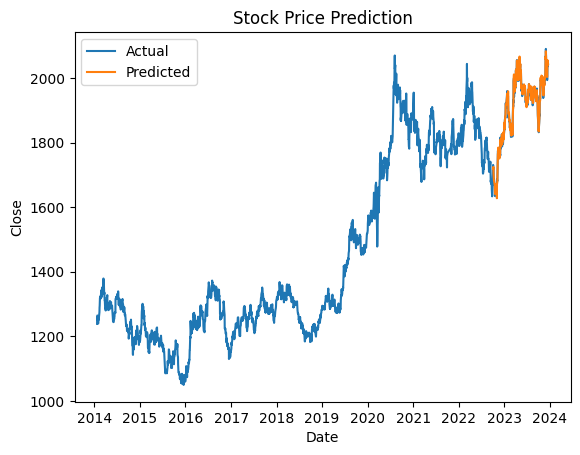

In [27]:
# let's visualize the score,predictions by predicting againt test data

predsl = l_model.predict(test_X) 
predsl = predsl.flatten() 

predsl = pd.Series(predsl,index=test_y.index)
l_model.score(test_X,test_y)

plot_results(test_X,test_y,predsl)

In [28]:
backtest(gold,l_model,predictors)

score_l_bt = l_model.score(test_X,test_y)

print(score_l_bt)

0.9956622598278979


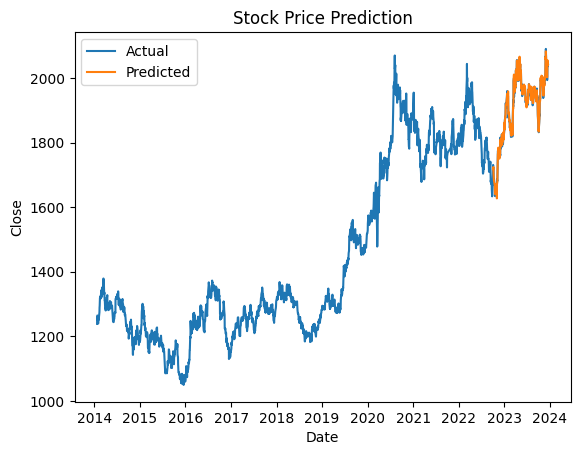

In [29]:
# let's visualize the score,predictions by predicting againt test data

preds = l_model.predict(test_X) 
preds = pd.Series(preds, index=test_X.index)

plot_results(test_X,test_y,preds)

## Observation & Conclusion

* RandomForestRegressor before Backtest = 0.987081875736736
* RandomForestRegressor after Backtest = 0.9998586264061423

* LinearRegressor befor Backtest = 0.9998586264061423
* LinearRegressor after Backtest =0.9915684072008302

So we can see that Both's without regressor doesn't perform better than their backtest one's, While Liner Regressor,Forest Regressor with backtest performs the best overall, score difers due to size of training data 

# Testing

Testing would be done for only the backtested model as the perform better than simple ones


2024-01-18	2021.6	167013.0	2009.1	2025.6	2007.7

predictors = ['Volume','Open','High','Low','Month','Day']

target = ['Close']

In [30]:

new_data = {
    # 'Date' : '2024-13-06',
   'Volume': [167013.0],
    'Open': [2009.1],
    'High': [2025.6],
    'Low': [2007.7],
    'Month' : [6],
   
}

df = pd.DataFrame(new_data)

print(r_model.predict(df))

## approximately correct actual price was 2021.6

[2019.924]


In [31]:
new_data = {
    # 'Date' : '2024-13-06',
     'Volume': [167013.0],
    'Open': [2009.1],
    'High': [2025.6],
    'Low': [2007.7],
    'Month' : [6],

}

df = pd.DataFrame(new_data)

print(l_model.predict(df))

## approximately correct actual price was 2021.6

[2020.47012498]


Results are approximately correct

# Modeling | stacked LSTM

In [32]:
gold

,Close,Volume,Open,High,Low,MovingAverage_month,Close_diff2,Close_log,Daily Returns,Month
Date,,,,,,,,,,
2023-12-18,2040.5,137436.0,2033.3,2048.0,2029.5,2048.490476,2047.7,7.620950,-0.005653,12
2023-12-15,2035.7,166565.0,2051.3,2059.6,2029.2,2049.161905,2052.1,7.618595,-0.002352,12
2023-12-14,2044.9,222776.0,2043.2,2062.9,2039.1,2050.990476,2040.5,7.623104,0.004519,12
2023-12-13,1997.3,183780.0,1995.1,2043.3,1987.9,2049.423810,2035.7,7.599552,-0.023277,12
2023-12-12,1993.2,140257.0,1997.8,2012.5,1992.3,2046.642857,2044.9,7.597497,-0.002053,12
...,...,...,...,...,...,...,...,...,...,...
2014-01-28,1250.5,81426.0,1254.9,1261.9,1248.0,1288.347619,1242.5,7.131299,-0.009270,1
2014-01-27,1263.5,63419.0,1269.9,1280.1,1252.0,1285.276190,1262.2,7.141641,0.010396,1
2014-01-24,1264.5,34998.0,1264.3,1273.2,1256.9,1281.552381,1250.5,7.142432,0.000791,1


* Even if the regression model have a good predictive score doesn't mean that they are the best suited, as they do not offer stability, Stationarity in the dataset,
Below is a explaination

In [34]:
# Differencing
if gold.index.duplicated().any():
    gold = gold[~gold.index.duplicated(keep='first')]

gold = gold.dropna()

result = adfuller(gold['Close'])

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# use of null-hypothestis testing for checking stationary ability of a feature in data set
if result[0]>(-2) and result[1]>0.05:
    print('goldstock is a Non-stationary data')
else:
    print('goldstock is a stationary data')



ADF Statistic: -1.7584584268988666
p-value: 0.4012720983846835
goldstock is a Non-stationary data


* As seen from time series analysis in the start the data is in consistent To overcome this inconsistency

 we'll use the multivariate LSTM model, which is a common choice for time series forecasting. We'll go through the steps of preprocessing, splitting the data, training the model, and making predictions.

In [35]:
df2 = df2.reset_index()['Close']

* Setting up scaler to scale the Close prics in between (0,1) because actual one's are sensitive for LSTM

In [36]:
scaler = MinMaxScaler(feature_range=(0,1))
df2 = scaler.fit_transform(np.array(df2).reshape(-1,1))
# we will use inverse_tranform at last to re-tranform to actual values

In [37]:
print(df2)

[[0.93885961]
 [0.93148059]
 [0.91701006]
 ...
 [0.20594154]
 [0.20402492]
 [0.18112123]]


In [38]:
df2.shape

(2511, 1)

* Train test Split

In [39]:
# Defining the size 65% for training and 35% for testing
training_size = int(len(df2)*0.65)
test_size = len(df2) - training_size

train, test = df2[0:training_size,:],df2[training_size:len(df2),:1]

In [40]:
# verifying splits
(len(train), len(test) )== (training_size, test_size)
print(training_size, test_size)

1632 879


* Function to define num of features & timesteps , return a total list of them. 

In [41]:
def create_dataset(df,timestep=1):
    X,y=[],[]
    for i in range(len(df)-timestep-1):
        a = df[i:(i+timestep),0]
        X.append(a)
        y.append(df[i+timestep,0])
    return np.array(X),np.array(y)

In [43]:
timestep = 252 # a year of trade days record will be used for predicting a new single record
X_train,y_train = create_dataset(train,timestep)
X_test,y_test = create_dataset(test,timestep)

In [44]:
## veryfying the datasets using their shapes,features
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(1379, 252) (1379,) (626, 252) (626,)


the number of records for train & test matches for both datasets
also the features also matches

* Reshaping the data is crucial in order to train & test the model to 3D

In [45]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [46]:
# new shapes
print(X_train.shape,X_test.shape)
n_features = X_train.shape[1]

(1379, 252, 1) (626, 252, 1)


* Training the stacked LSTM

In [49]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense

In [50]:
lstm_model = Sequential()
lstm_model.add(LSTM(50,return_sequences=True,input_shape=(n_features,1)))
lstm_model.add(LSTM(50,return_sequences=True))
lstm_model.add(LSTM(50))
lstm_model.add(Dense(1))

In [51]:
lstm_model.compile(loss='mean_squared_error',optimizer="adam")

In [52]:
lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 252, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 252, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

* Fitting the training data to lstm_model

while fitting the data be aware of that the losses must go on decreaseing

In [54]:
lstm_model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 341ms/step - loss: 0.0012 - val_loss: 7.4121e-04
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 337ms/step - loss: 0.0012 - val_loss: 7.3692e-04
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 349ms/step - loss: 9.8274e-04 - val_loss: 7.3288e-04
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 342ms/step - loss: 0.0010 - val_loss: 7.0857e-04
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 340ms/step - loss: 9.7324e-04 - val_loss: 7.0085e-04
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 335ms/step - loss: 9.7805e-04 - val_loss: 6.8173e-04
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 347ms/step - loss: 8.8165e-04 - val_loss: 6.8433e-04
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 338ms/step - loss: 9.1001e-04 - val_loss: 6.5287e-04
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 339ms/step - loss: 9.4655e-04 - val_loss: 6.4035e-04
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 349ms/step - loss: 9.1141e-04 - val_loss: 6.4566e-04
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 336ms/step - 

In [55]:
train_predict = lstm_model.predict(X_train)
test_predict = lstm_model.predict(X_test)
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step


* for score metrics

In [56]:
math.sqrt(mean_squared_error(y_train,train_predict))

1613.7327649698925

In [57]:
math.sqrt(mean_squared_error(y_test,test_predict))

1223.2024793357089

In [58]:
print(train_predict.shape,test_predict.shape)

(1379, 1) (626, 1)


* Plotting the results

In [59]:
train_dates = df.index[:len(train_predict)]
test_dates = df.index[len(train_predict):len(train_predict)+626]
train_dates

RangeIndex(start=0, stop=1, step=1)

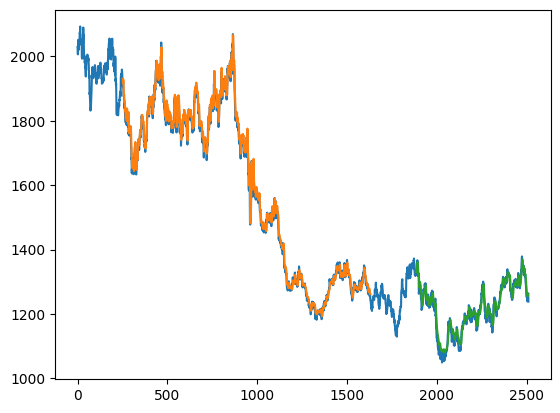

In [60]:
lookback=252
trainPredictPlot = np.empty_like(df2)
trainPredictPlot[:,:]=np.nan
trainPredictPlot[lookback:len(train_predict)+lookback,:] =train_predict

testPredictPlot = np.empty_like(df2)
testPredictPlot[:,:]=np.nan
testPredictPlot[len(train_predict)+(lookback*2)+1:len(df2)-1, :] =test_predict

plt.plot(scaler.inverse_transform(df2))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()
# Blue - actual close prices 
# Orange - predicted close prices while training model
# Green - predicted close prices while testing model

# Forecast

In [158]:
len(test)
#879-252=627 bc we need last 252 days to predict next day

879

In [159]:
x_input = test[627:].reshape(1,-1)
print(x_input.shape)

(1, 252)


In [160]:
# reshaping the data for smooth prediction as LSTM is too sensitive
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [171]:
from numpy import array
list_output = []
n_steps = 252
predicted_records=0
# iteratively predicting 252 record & appending them to list_output
while(predicted_records<100):
    if(len(temp_input)>252):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(predicted_records,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = lstm_model.predict(x_input, verbose=0)
        print("{} day output {}".format(predicted_records,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        list_output.extend(yhat.tolist())
        predicted_records=predicted_records+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = lstm_model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        list_output.extend(yhat.tolist())
        predicted_records=predicted_records+1
print(list_output)

0 day input [0.22405367 0.22577863 0.21974126 0.22098706 0.21638716 0.23536176
 0.23679923 0.23929085 0.24590321 0.25500719 0.25385721 0.25011979
 0.25002396 0.25050311 0.25194058 0.24781984 0.22587446 0.22932439
 0.23497844 0.22347868 0.2369909  0.24044082 0.24551989 0.24504073
 0.23296598 0.2461907  0.24762817 0.25481552 0.24896981 0.25615716
 0.23977    0.23718256 0.24638237 0.27580259 0.27752755 0.26324868
 0.25577384 0.25625299 0.25970292 0.26957355 0.2654528  0.26104456
 0.25912793 0.25625299 0.26161955 0.26037374 0.25759463 0.25586967
 0.25347389 0.21379971 0.21312889 0.21629133 0.21514135 0.21504552
 0.20277911 0.20172496 0.19578342 0.19444178 0.19520843 0.18658361
 0.18677528 0.18629612 0.18821275 0.19885002 0.20134164 0.20709152
 0.23219933 0.23536176 0.22855774 0.23478678 0.23402012 0.2336368
 0.23382846 0.24561572 0.23497844 0.23593675 0.22807858 0.22817441
 0.22932439 0.24820316 0.24887398 0.24274078 0.22405367 0.23603258
 0.23641591 0.23900335 0.24072832 0.23095352 0.2252

In [172]:
day_new=np.arange(1,253)
day_pred=np.arange(253,353)

In [173]:
len(df2)
#2511

2511

In [174]:
data1=scaler.inverse_transform(df2[2259:])
data1

array([[1293.7],
       [1294.2],
       [1276.9],
       [1264.8],
       [1234.5],
       [1234.4],
       [1232.8],
       [1216.1],
       [1208.5],
       [1210.7],
       [1219.4],
       [1204. ],
       [1186.2],
       [1184.1],
       [1200.4],
       [1181.9],
       [1195.3],
       [1173.5],
       [1178. ],
       [1179.8],
       [1196. ],
       [1194.8],
       [1194.5],
       [1194.3],
       [1207.7],
       [1222.5],
       [1225.6],
       [1229.4],
       [1232. ],
       [1194.9],
       [1190.4],
       [1207.7],
       [1208.7],
       [1199.4],
       [1218.1],
       [1175.5],
       [1197.5],
       [1197.8],
       [1196.6],
       [1197.7],
       [1190.9],
       [1193.9],
       [1197.1],
       [1183.5],
       [1185.6],
       [1161.5],
       [1159.1],
       [1163. ],
       [1159.8],
       [1169.8],
       [1142.6],
       [1145.7],
       [1167.7],
       [1169.8],
       [1171.6],
       [1198.6],
       [1224.9],
       [1229.4],
       [1229.3

In [175]:
list_output = scaler.inverse_transform(list_output)
list_output

array([[1282.79553458],
       [1283.00241884],
       [1283.20813689],
       [1283.41268875],
       [1283.6160433 ],
       [1283.81832494],
       [1284.01937819],
       [1284.21945183],
       [1284.41834371],
       [1284.61613159],
       [1284.81287767],
       [1285.00848864],
       [1285.20310445],
       [1285.39658516],
       [1285.58911735],
       [1285.78059219],
       [1285.97100968],
       [1286.160432  ],
       [1286.34884362],
       [1286.53632227],
       [1286.72274357],
       [1286.90820081],
       [1287.09270953],
       [1287.27626975],
       [1287.458897  ],
       [1287.64059129],
       [1287.82124378],
       [1288.00110324],
       [1288.17999865],
       [1288.35800774],
       [1288.53506832],
       [1288.71125814],
       [1288.88657719],
       [1289.06097884],
       [1289.23457191],
       [1289.40726312],
       [1289.57913022],
       [1289.75023539],
       [1289.92040761],
       [1290.08980235],
       [1290.25837298],
       [1290.426

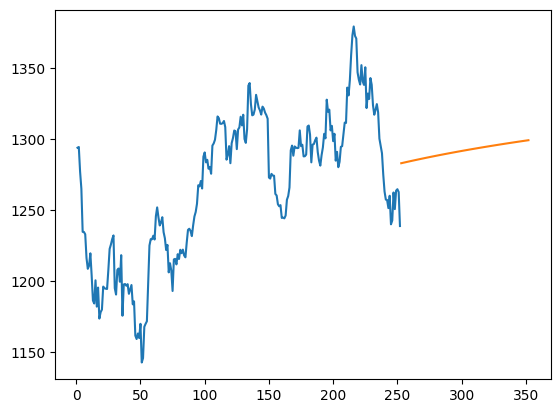

In [176]:
# 2511-252 = 2259
plt.plot(day_new,data1)
plt.plot(day_pred,list_output)

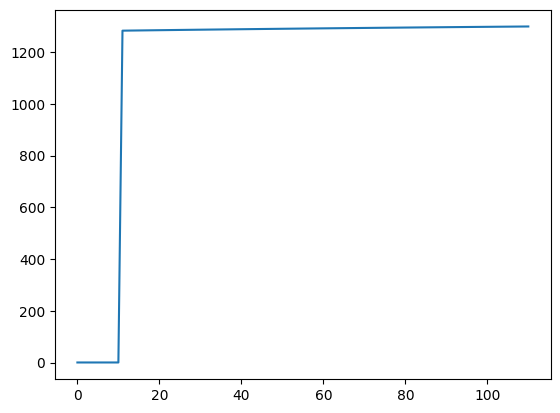

In [177]:
# by extending the new df3 we join our actual data & forecasted one's
df3 = df2.tolist()
df3.extend(list_output)
plt.plot(df3[2500:])

# Trading Strategy Development

## Formulate and Backtest  Strategies
### Formulate Strategies: Define clear trading strategies based on your ML model predictions. For example:
* Trend Following: Buy when the model predicts a price increase and sell when it predicts a decrease.
* Mean Reversion: Buy when the price is significantly below the predicted value and sell when it is above.


### Evaluate Performance: Calculate key performance metrics like return on investment (ROI), Sharpe ratio, and drawdown.

* Explore Reverse Trading Strategies
    Reverse Strategies: Test reverse strategies where you do the opposite of what the model suggests (e.g., sell when it predicts a price increase).

# Exporting the model in pkl

In [179]:
joblib.dump(r_model,'GPP_r_model.pkl')
joblib.dump(l_model,'GPP_l_model.pkl')
joblib.dump(lstm_model,'GPP_lstm_model.pkl')

['GPP_lstm_model.pkl']